In [1]:
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

# load dataset
data = joblib.load("../data/train_test.pkl")

X_test = data["X_test"]
y_test = data["y_test"]

# load model
bundle = joblib.load("../models/predictive_maintenance_model.pkl")
model = bundle["model"]
threshold = bundle["threshold"]
columns = bundle["columns"]

# clean columns for XGBoost
def clean_columns(df):
    df = df.copy()
    df.columns = (
        df.columns
        .str.replace('[','',regex=False)
        .str.replace(']','',regex=False)
        .str.replace(' ','_')
        .str.replace('/','')
    )
    return df

X_test = clean_columns(X_test)
probs = model.predict_proba(X_test)[:,1]
preds = (probs >= threshold).astype(int)

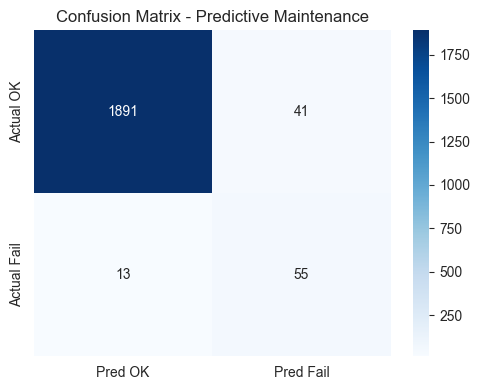

In [2]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, preds)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Pred OK','Pred Fail'],
            yticklabels=['Actual OK','Actual Fail'])
plt.title("Confusion Matrix - Predictive Maintenance")
plt.tight_layout()
plt.show()

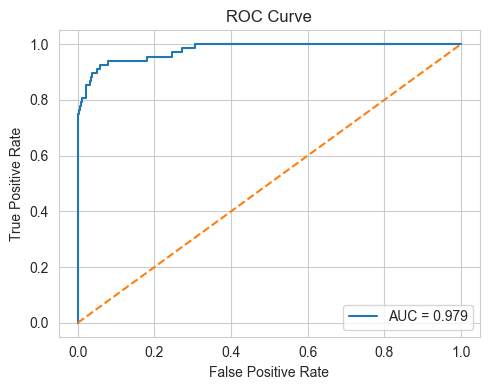

In [3]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_test, probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(5,4))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1],[0,1],'--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.tight_layout()
plt.show()

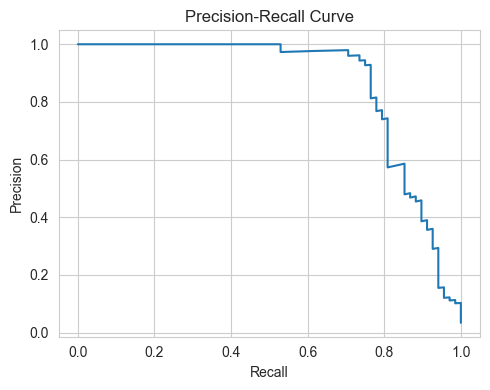

In [4]:
from sklearn.metrics import precision_recall_curve

precision, recall, _ = precision_recall_curve(y_test, probs)

plt.figure(figsize=(5,4))
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.tight_layout()
plt.show()

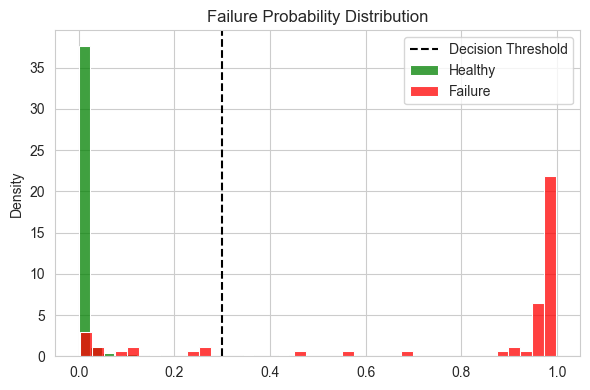

In [5]:
plt.figure(figsize=(6,4))
sns.histplot(probs[y_test==0], label="Healthy", color="green", bins=40, stat="density")
sns.histplot(probs[y_test==1], label="Failure", color="red", bins=40, stat="density")
plt.axvline(threshold, color='black', linestyle='--', label='Decision Threshold')
plt.legend()
plt.title("Failure Probability Distribution")
plt.tight_layout()
plt.show()

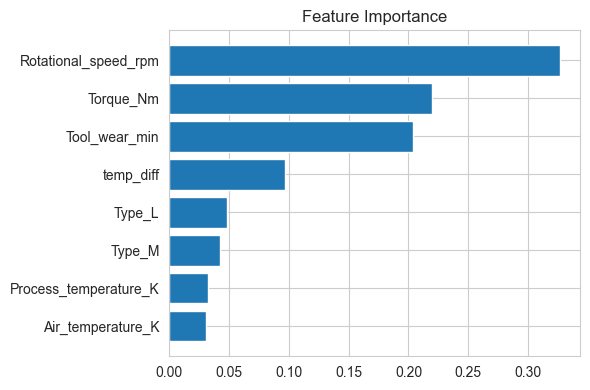

In [6]:
importance = model.feature_importances_

feat_imp = pd.DataFrame({
    "Feature": columns,
    "Importance": importance
}).sort_values(by="Importance", ascending=True)

plt.figure(figsize=(6,4))
plt.barh(feat_imp["Feature"], feat_imp["Importance"])
plt.title("Feature Importance")
plt.tight_layout()
plt.show()

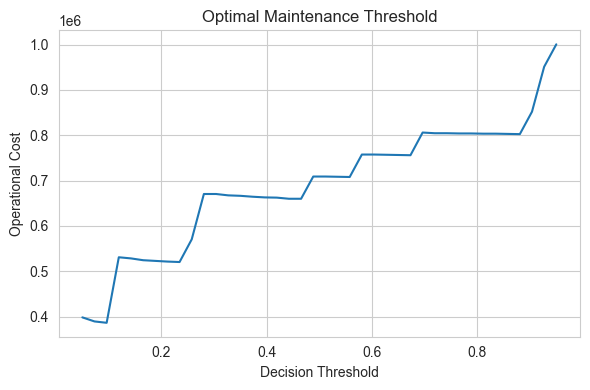

In [7]:
costs = []
thresholds = np.linspace(0.05,0.95,40)

FAIL_COST = 50000
INSPECT_COST = 500

for t in thresholds:
    pred = (probs >= t).astype(int)
    cm = confusion_matrix(y_test, pred)
    missed_failures = cm[1,0]
    inspections = cm[0,1]

    total_cost = missed_failures*FAIL_COST + inspections*INSPECT_COST
    costs.append(total_cost)

plt.figure(figsize=(6,4))
plt.plot(thresholds, costs)
plt.xlabel("Decision Threshold")
plt.ylabel("Operational Cost")
plt.title("Optimal Maintenance Threshold")
plt.tight_layout()
plt.show()